In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hBeta import PThBeta
import seaborn as sns
import collections
from preprocessing import epi_year_cases_matrix
import matplotlib.lines as mlines
from collections import defaultdict
from utils.utils_func import _sim_square_pos
from lalonde import _load_lalonde
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from causallib.estimation import StratifiedStandardization, Standardization
from sklearn.ensemble import RandomForestRegressor
from utils.utils_summary import _load_pickle, _dyadic_cube_to_samples, _dyadic_prediction, _dyadic_cube_to_samples222

### Load saved files

In [130]:
DIR_LAN = 'C:\\Users\\itaym\\Google Drive\\University - Itay\\Msc\\Thesis\\Epi\\Results\\Lanlonde\\XY\\'

def _load_pickle(file=('3_9_1_org'), data='XY_lalonde'):
    dir = DIR_LAN if data == 'XY_lalonde' else DIR_SIM
    file = dir + data + '_' + file + '.pickle'
    with (open(file, "rb")) as openfile:
        d_res, d_info = pickle.load(openfile)
    return d_res, d_info


In [145]:
# d_res, d_info = _load_pickle(file=('3_9_1_org'))

# d_res, d_info = _load_pickle(file=('3_9_1_org_upsam'))
d_res, d_info = _load_pickle(file=('3_9_1_many_p'))
d_res_lo, d_info_lo = _load_pickle(file=('3_9_1_left_out'))

# d_res, d_info = _load_pickle(file=('2_10_1_org'))
# d_res, d_info = _load_pickle(file=('2_10_1_gamma_01_org'))

In [146]:
d_res

defaultdict(dict,
            {'treated(0, 0, 0, 0)': {'y_given_x':                y        0              1
              0   27693.245827  11.6125  -16526.357438
              1   22700.678372  11.6125    9181.309687
              2   36207.485164  11.6125   34888.976812
              3   36243.077684  11.6125   60596.643937
              4   46758.494923  11.6125   86304.311062
              ..           ...      ...            ...
              59  43456.803306  59.3875   60596.643937
              60  50242.863995  59.3875   86304.311062
              61  50521.317687  59.3875  112011.978187
              62  51106.976432  59.3875  137719.645312
              63  50654.997647  59.3875  163427.312438
              
              [64 rows x 3 columns],
              'p_x_a':          p_x        0              1
              0   0.024078  11.6125  -16526.357438
              1   0.033936  11.6125    9181.309687
              2   0.013794  11.6125   34888.976812
              3   0.0

### Load data

In [61]:
# load data
X, y, a = _load_lalonde()

X_y = pd.concat([X, y], axis=1)

print(X_y.shape)

(22106, 10)
(22106, 9)


In [208]:
X_y.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,age,education,black,hispanic,married,no_degree,re74,re75,re78
age,1.00,-0.11,-0.04,-0.01,0.46,0.02,0.40,0.35,0.17
education,-0.11,1.00,-0.16,-0.18,0.03,-0.74,0.17,0.20,0.21
black,-0.04,-0.16,1.00,-0.10,-0.10,0.16,-0.13,-0.14,-0.13
hispanic,-0.01,-0.18,-0.10,1.00,0.00,0.14,-0.06,-0.06,-0.05
married,0.46,0.03,-0.10,0.00,1.00,-0.10,0.43,0.41,0.28
no_degree,0.02,-0.74,0.16,0.14,-0.10,1.00,-0.22,-0.23,-0.20
re74,0.40,0.17,-0.13,-0.06,0.43,-0.22,1.00,0.87,0.67
re75,0.35,0.20,-0.14,-0.06,0.41,-0.23,0.87,1.00,0.70
re78,0.17,0.21,-0.13,-0.05,0.28,-0.20,0.67,0.70,1.00


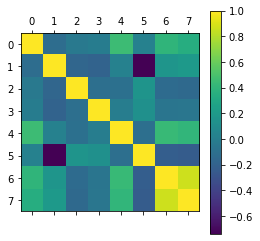

,age,education,black,hispanic,married,no_degree,re74,re75
age,1.00,-0.11,-0.04,-0.01,0.46,0.02,0.40,0.35
education,-0.11,1.00,-0.16,-0.18,0.03,-0.74,0.17,0.20
black,-0.04,-0.16,1.00,-0.10,-0.10,0.16,-0.13,-0.14
hispanic,-0.01,-0.18,-0.10,1.00,0.00,0.14,-0.06,-0.06
married,0.46,0.03,-0.10,0.00,1.00,-0.10,0.43,0.41
no_degree,0.02,-0.74,0.16,0.14,-0.10,1.00,-0.22,-0.23
re74,0.40,0.17,-0.13,-0.06,0.43,-0.22,1.00,0.87
re75,0.35,0.20,-0.14,-0.06,0.41,-0.23,0.87,1.00


In [201]:
plt.matshow(X.corr())
plt.colorbar()
plt.show()

X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

In [199]:
corr_1 = ['re74', 're75', 'education', 'no_degree']
corr_2 = ['age', 'married', '']

,age,education,black,hispanic,married,no_degree,re74,re75
16827,26.0,13.0,0.0,0.0,0.0,0.0,58.778,50.12903
5412,27.0,12.0,0.0,0.0,1.0,0.0,16297.180,13429.21000
15399,26.0,12.0,0.0,0.0,0.0,0.0,5217.527,3174.24200
13077,38.0,16.0,0.0,0.0,1.0,0.0,23713.010,9178.98400
2189,55.0,8.0,0.0,0.0,1.0,1.0,0.000,0.00000
...,...,...,...,...,...,...,...,...
11964,29.0,18.0,0.0,0.0,1.0,0.0,10329.250,3580.64500
21575,17.0,10.0,1.0,0.0,0.0,1.0,0.000,0.00000
5390,29.0,12.0,1.0,0.0,1.0,0.0,17308.160,5473.01600
860,22.0,12.0,0.0,0.0,1.0,0.0,12051.450,16025.17700


In [183]:
X.loc[:, ['re74', 're75', 'education', 'no_degree', 'age', 'married']]


pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=3))])

X_trans = pipeline['scaling'].fit_transform(X.loc[:, ['re74', 're75', 'education', 'no_degree', 'age', 'married']])

In [200]:
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=3))])
X_trans = pd.DataFrame(pipeline['scaling'].fit_transform(X.loc[:, corr_1]),
                     columns = corr_1)
principalComponents = pd.DataFrame(pipeline['pca'].fit_transform(X_trans))

np.sum(pipeline['pca'].explained_variance_ratio_)

0.9669301150971386

In [177]:
X_trans

,re74,re75,education,no_degree,age,married
0,-1.294202,-1.261865,0.395738,-0.705764,-0.595665,-1.483259
1,0.260807,0.042563,0.049536,-0.705764,-0.506476,0.674191
2,-0.800194,-0.957272,0.049536,-0.705764,-0.595665,-1.483259
3,0.970957,-0.371823,1.434343,-0.705764,0.474603,0.674191
4,-1.299831,-1.266753,-1.335272,1.416905,1.990815,0.674191
...,...,...,...,...,...,...
22101,-0.310689,-0.917648,2.126747,-0.705764,-0.328098,0.674191
22102,-1.299831,-1.266753,-0.642868,1.416905,-1.398365,-1.483259
22103,0.357620,-0.733147,0.049536,-0.705764,-0.328098,0.674191
22104,-0.145769,0.295664,0.049536,-0.705764,-0.952421,0.674191


In [194]:
X.loc[:, ['black', 'hispanic']]

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=3))])
X_trans = pd.DataFrame(pipeline['scaling'].fit_transform(X.loc[:, ['black', 'hispanic', 'married']]),
                     columns = ['black', 'hispanic', 'married'])
principalComponents = pd.DataFrame(pipeline['pca'].fit_transform(X_trans))

np.sum(pipeline['pca'].explained_variance_ratio_)

1.0

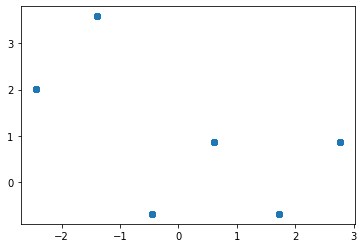

In [197]:
plt.scatter(x=principalComponents.iloc[:,0], y=principalComponents.iloc[:,1])

In [99]:
from sklearn.decomposition import PCA
from statsmodels.multivariate.pca import PCA


X_y = pd.concat([X,y], axis = 1)


In [131]:
pca = PCA(n_components=20)


In [79]:
w = 0.001 * np.ones(a.shape[0])

w[a==1] = 1
w = w#.reshape(-1, 1)

w.shape

(22106,)

In [81]:
pc = PCA(X_y, standardize=True, ncomp=2, weights=w)

In [98]:
errors = pc.projection

var = (errors ** 2.0).mean(0)
weights = 1.0 / var
weights.shape

(28,)

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=20)
std = StandardScaler()
tansormed = std.fit_transform(X)
principalComponents = pd.DataFrame(pca.fit_transform(tansormed))#pca.fit_transform(X_y))

pcr = make_pipeline(StandardScaler(), PCA(n_components=2))
pcr.fit(X_y)


pca_r = pcr.named_steps['pca'] 


In [134]:
pca.explained_variance_ratio_

array([0.12611305, 0.07529561, 0.05215774, 0.04793255, 0.043108  ,
       0.04065187, 0.04004114, 0.03972649, 0.03961037, 0.03931882,
       0.03879961, 0.03831255, 0.03815754, 0.03775652, 0.037492  ,
       0.03731685, 0.03723591, 0.03703774, 0.03644922, 0.03399145])

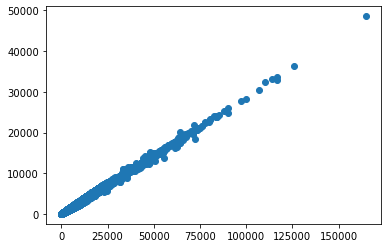

In [114]:
principalComponents = pca_r.transform(X_y)

plt.scatter(principalComponents[:,0], principalComponents[:, 1])

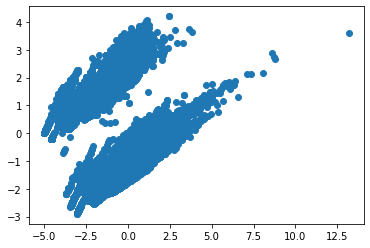

In [130]:
plt.scatter(principalComponents.iloc[:,0], principalComponents.iloc[:, 1])

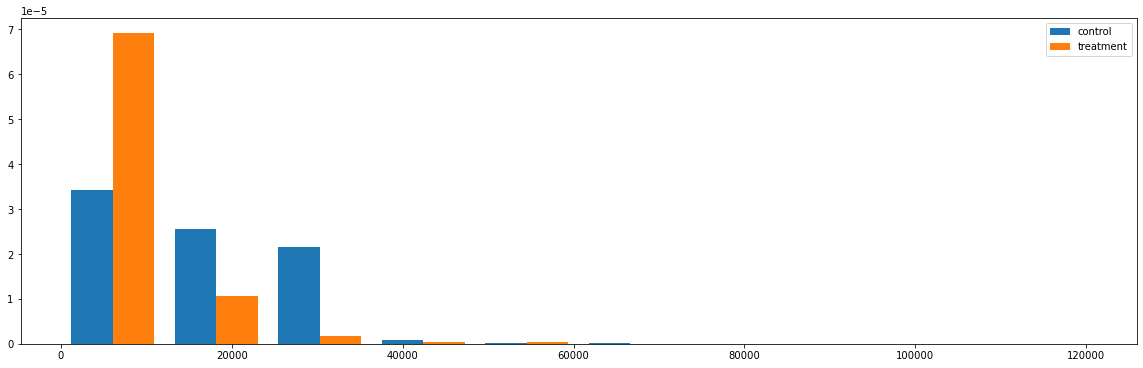

In [7]:
plt.subplots(figsize=(20,6))
plt.hist([y.loc[a==0], y.loc[a==1]], density=True, label=['control', 'treatment'])
plt.legend()

([<matplotlib.axis.YTick at 0x2a7db838d88>,
 [Text(0, 1, 'Control'), Text(0, 2, 'Treatment')])

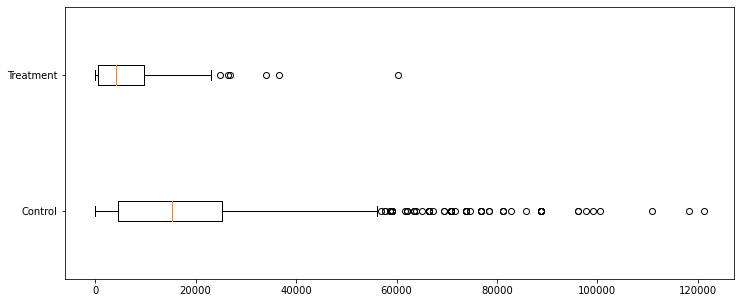

In [136]:
plt.subplots(figsize=(12,5))
plt.boxplot([y.loc[a==0], y.loc[a==1]], vert=False)
plt.yticks([1, 2], ('Control', 'Treatment'))

In [8]:
pca = PCA(n_components=d_info['dim'] - 1)
principalComponents = pd.DataFrame(pca.fit_transform(X), index=X.index)
pca_full = pd.DataFrame(principalComponents)
df_full = pd.concat([y, pca_full], axis=1)

pt = PThBeta(seg_1dim=d_info['seg_1dim'])
pt.set_int_coords(data=df_full, gamma=d_info['gamma'], sup_01=False)

### Define the space with PThbeta

In [9]:
d_info

{'data': 'lalonde',
 'dim': 3,
 'seg_1dim': 3,
 'n_pts': 600,
 'a_0': 1,
 'gamma': 0.2,
 'plot_pred': True,
 'transform': 'org',
 'loo': False,
 'positivity': False,
 'X_and_Y': False,
 'level': 9}

In [10]:
y_given_x = pt.conditional_expected(d_res['treated']['pi'],d_res['treated']['seg_pdist'])
p_x_treated = pt.marginalizing_y(d_res['treated']['pi'],d_res['treated']['seg_pdist'])

KeyError: 'pi'

In [16]:
y_given_x_control = pt.conditional_expected(d_res['control']['pi'],d_res['control']['seg_pdist'])
p_x_control = pt.marginalizing_y(d_res['control']['pi'],d_res['control']['seg_pdist'])

KeyError: 'pi'

In [137]:
# y given x with already calculated data data

y_given_x = d_res['treated']['y_given_x']
p_x_treated = d_res['treated']['p_x_a']

y_given_x_control = d_res['control']['y_given_x']
p_x_control = d_res['control']['p_x_a']


Summay statistics of y:
count     22106.000000
mean      14645.443781
std       10856.237319
min           0.000000
25%        4461.257000
50%       15185.120000
75%       25207.062500
max      121173.580000
Name: re78, dtype: float64


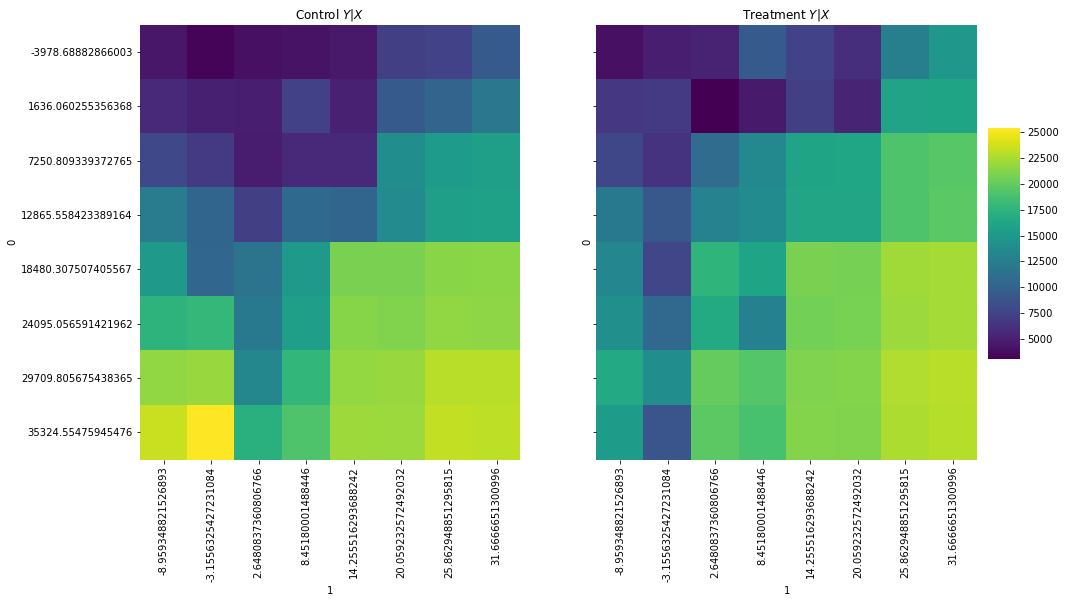

In [138]:
import seaborn as sns

fig, axn = plt.subplots(ncols=2, figsize=(15, 8), sharey=True, sharex=True)
# fig2, axn2 = plt.subplots(ncols=2, figsize=(15, 8))#, sharey=True, sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

print('Summay statistics of y:')
print(y.describe())

for i, ax in enumerate(axn.flat):
    if i == 0:
        df_heat = y_given_x_control.pivot(0, 1, "y")
        ax.set_title('Control $Y|X$')
    else:
        df_heat = y_given_x.pivot(0, 1, "y")
        ax.set_title('Treatment $Y|X$')
    sns.heatmap(df_heat, ax=ax,
                cbar=i == 0,
                vmin=y_given_x['y'].min(), vmax=y_given_x_control['y'].max(),
                cbar_ax=None if i else cbar_ax,
                cmap = plt.get_cmap('viridis'))
    


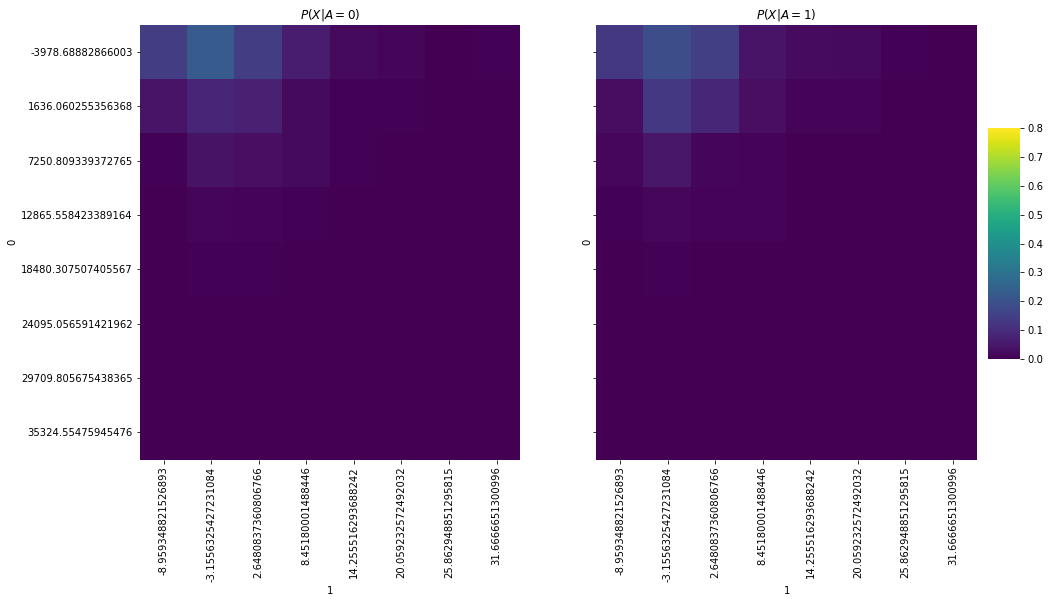

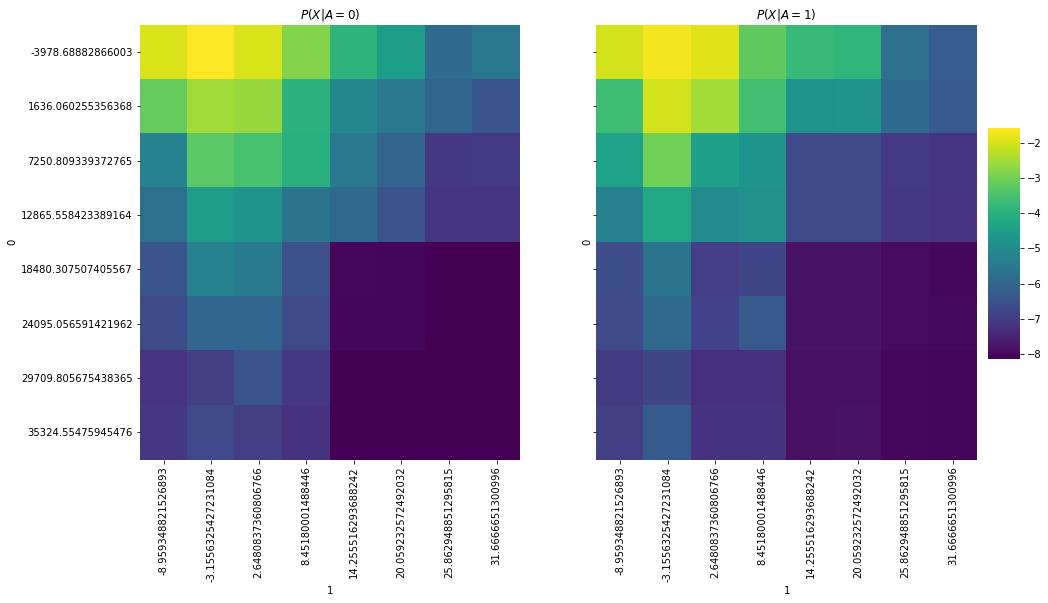

In [139]:
p_x = (p_x_treated + p_x_control)/2

fig, axn = plt.subplots(ncols=2, figsize=(15, 8), sharey=True, sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    if i == 0:
        df_heat = p_x_control.pivot(0, 1, "p_x")
        ax.set_title('$P(X|A=0)$')
    else:
        df_heat = p_x_treated.pivot(0, 1, "p_x")
        ax.set_title('$P(X|A=1)$')
    sns.heatmap(df_heat, ax=ax,
                cbar=i == 0,
                vmin=0, vmax=0.8,             
                cbar_ax=None if i else cbar_ax,
                cmap = plt.get_cmap('viridis'))
    
    
fig, axn = plt.subplots(ncols=2, figsize=(15, 8), sharey=True, sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    if i == 0:
        df_heat = p_x_control.pivot(0, 1, "p_x")
        ax.set_title('$P(X|A=0)$')
    else:
        df_heat = p_x_treated.pivot(0, 1, "p_x")
        ax.set_title('$P(X|A=1)$')
    sns.heatmap(np.log(df_heat), ax=ax,
                cbar=i == 0,
                vmin=np.log(p_x['p_x'].min()), vmax=np.log(p_x['p_x'].max()),             
                cbar_ax=None if i else cbar_ax,
                cmap = plt.get_cmap('viridis'))

In [140]:
p_x = (p_x_treated + p_x_control)/2

np.sum(p_x['p_x'])

0.9995

In [146]:
ATE = np.sum((y_given_x['y'] - y_given_x_control['y']) * p_x['p_x'])
ATT = np.sum((y_given_x['y'] - y_given_x_control['y']) * p_x_treated['p_x'])

print('ATE: {:f}\nATT: {:f}'.format(ATE, ATT))

ATE: 1081.094142
ATT: 860.784818


In [142]:
p_x_treated['p_x'].sort_values(ascending=False)


y_given_x_control['y'].iloc[39]

21440.713260528562

In [143]:
p_x_treated['p_x'][np.max(p_x_treated['p_x']) == p_x_treated['p_x']]

1    0.184326
Name: p_x, dtype: float16

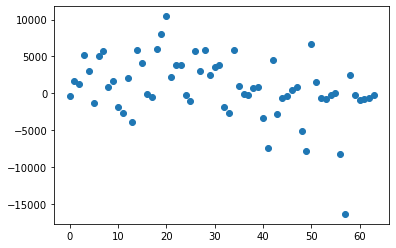

In [144]:
plt.scatter(y_given_x['y'].index,y_given_x['y'] - y_given_x_control['y'])

In [145]:
print((y_given_x['y'] - y_given_x_control['y']).sort_values(ascending=False).to_string())

20    10463.602078
19     7986.917371
50     6709.275617
18     6016.985297
34     5923.184074
28     5858.676233
14     5843.734063
26     5712.245273
7      5679.094132
3      5168.128590
6      5094.762136
42     4497.213394
15     4159.996583
22     3857.311252
23     3853.032201
31     3786.269806
30     3549.403638
27     3054.057494
4      2979.182732
58     2529.011057
29     2483.758944
21     2204.677409
12     2107.162212
1      1701.341116
9      1687.155257
51     1599.996916
2      1227.603029
35      997.985078
8       919.630711
39      876.055135
47      818.633034
38      709.218165
46      382.998054
55       27.698802
36      -38.741514
16      -55.748440
37     -179.260021
24     -243.744857
59     -263.506710
54     -294.472314
63     -294.564337
45     -348.213512
0      -430.496812
17     -525.890457
62     -666.611702
52     -667.255860
44     -677.102278
53     -733.328086
61     -827.651249
60     -875.595023
25    -1104.777303
5     -1255.455681
32    -1809.

In [148]:
np.sum((d_res['treated']['y_given_x']['y'] - d_res['control']['y_given_x']['y']) * d_res['treated']['p_x_a']['p_x'])

-5509.793347574164

In [32]:
d_res['treated']

{'pca_model': PCA(n_components=2),
 'y_given_x':                 y              0             1
 0    34051.156230  -51225.235612 -67510.025999
 1    34540.876954  -51225.235612 -58475.018076
 2    30187.339690  -51225.235612 -49440.010154
 3    28899.416251  -51225.235612 -40405.002231
 4    27758.392851  -51225.235612 -31369.994309
 ..            ...            ...           ...
 251  42139.417812  221243.566171  31875.061149
 252  48488.903882  221243.566171  40910.069072
 253  45551.353794  221243.566171  49945.076994
 254  45203.240455  221243.566171  58980.084917
 255  44396.977421  221243.566171  68015.092839
 
 [256 rows x 3 columns],
 'p_x_a':           p_x              0             1
 0    0.000397  -51225.235612 -67510.025999
 1    0.000372  -51225.235612 -58475.018076
 2    0.000420  -51225.235612 -49440.010154
 3    0.000400  -51225.235612 -40405.002231
 4    0.000933  -51225.235612 -31369.994309
 ..        ...            ...           ...
 251  0.000099  221243.566171  3

# 2d dimension

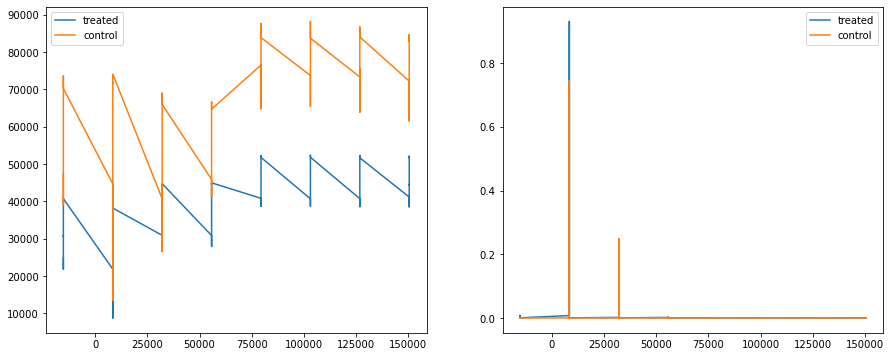

In [152]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(d_res['treated']['y_given_x'][0],d_res['treated']['y_given_x']['y'], label='treated')
ax[0].plot(d_res['control']['y_given_x'][0],d_res['control']['y_given_x']['y'], label='control')
ax[0].legend()

ax[1].plot(d_res['treated']['y_given_x'][0],d_res['treated']['p_x_a']['p_x'], label='treated')
ax[1].plot(d_res['control']['y_given_x'][0],d_res['control']['p_x_a']['p_x'], label='control')
ax[1].legend()

In [42]:
np.sum((d_res['treated']['y_given_x']['y'] - d_res['control']['y_given_x']['y']) * d_res['treated']['p_x_a']['p_x'])

-578.6114687417208

# X and Y together

In [98]:
# d_res, d_info = _load_pickle(file=('2_10_1_std_X_and_Y'))
d_res, d_info = _load_pickle(file=('3_9_1_std_X_and_Y'))
d_info

{'data': 'lalonde',
 'dim': 3,
 'seg_1dim': 3,
 'n_pts': 600,
 'a_0': 1,
 'gamma': 0.1,
 'plot_pred': True,
 'transform': 'org',
 'loo': False,
 'positivity': False,
 'X_and_Y': True,
 'level': 9}

In [35]:
# no standarize

from sklearn.pipeline import Pipeline
pipeline = Pipeline([('pca', PCA(n_components=d_info['dim']))])
XY = pd.concat([X, y], axis=1)
X_tr = pd.concat([XY.loc[a == 1, :]]*115, ignore_index=True)
X_cr = pd.concat([XY.loc[a == 0, :]]*1, ignore_index=True)
X_upsam = pd.concat([X_cr, X_tr], ignore_index=True)

principalComponents = pd.DataFrame(pipeline['pca'].fit_transform(X_upsam))
pca_full = pd.DataFrame(principalComponents)
pca_treated = pd.DataFrame(pipeline['pca'].transform(XY.loc[a == 1, :]), index=X.loc[a == 1, :].index)
pca_control = pd.DataFrame(pipeline['pca'].transform(XY.loc[a == 0, :]), index=X.loc[a == 0, :].index)


pt = PThBeta(seg_1dim=d_info['seg_1dim'])
pt.set_int_coords(data=pca_full, gamma=d_info['gamma'], sup_01=False)

In [99]:
# with standartization

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=d_info['dim']))])
XY = pd.concat([X, y], axis=1)
X_tr = pd.concat([XY.loc[a == 1, :]]*115, ignore_index=True)
X_cr = pd.concat([XY.loc[a == 0, :]]*1, ignore_index=True)
X_upsam = pd.concat([X_cr, X_tr], ignore_index=True)

X_trans = pipeline['scaling'].fit_transform(X_upsam)


principalComponents = pd.DataFrame(pipeline['pca'].fit_transform(X_trans))
pca_full = pd.DataFrame(principalComponents)
pca_treated = pd.DataFrame(pipeline['pca'].transform(X_trans[X_cr.shape[0]:X_cr.shape[0] + X.loc[a == 1, :].shape[0], :]),
                           index=X.loc[a == 1, :].index)
pca_control = pd.DataFrame(pipeline['pca'].transform(X_trans[:X_cr.shape[0], :]),
                           index=X.loc[a == 0, :].index)

pt = PThBeta(seg_1dim=d_info['seg_1dim'])
pt.set_int_coords(data=pca_full, gamma=d_info['gamma'], sup_01=False)

In [100]:
np.sum(pipeline['pca'].explained_variance_ratio_)

0.7149345740540994

In [111]:
d = pd.concat([pd.Series(d_res['treated']['pi'], name='y') ,pd.DataFrame(pt.arr_vec)], axis=1)

d = pd.concat([pd.Series(d_res['control']['pi'], name='y') ,pd.DataFrame(np.fliplr(pt.arr_med[:,:2]))], axis=1)

d
c = d.drop_duplicates(subset=[0, 1])
c

,y,0,1
0,0.000004,-3.243605,-3.431502
8,0.000004,-1.810182,-3.431502
16,0.000005,-0.376759,-3.431502
24,0.000006,1.056664,-3.431502
32,0.000013,2.490086,-3.431502
...,...,...,...
472,0.000004,1.056664,17.573095
480,0.000004,2.490086,17.573095
488,0.000011,3.923509,17.573095
496,0.000002,5.356932,17.573095


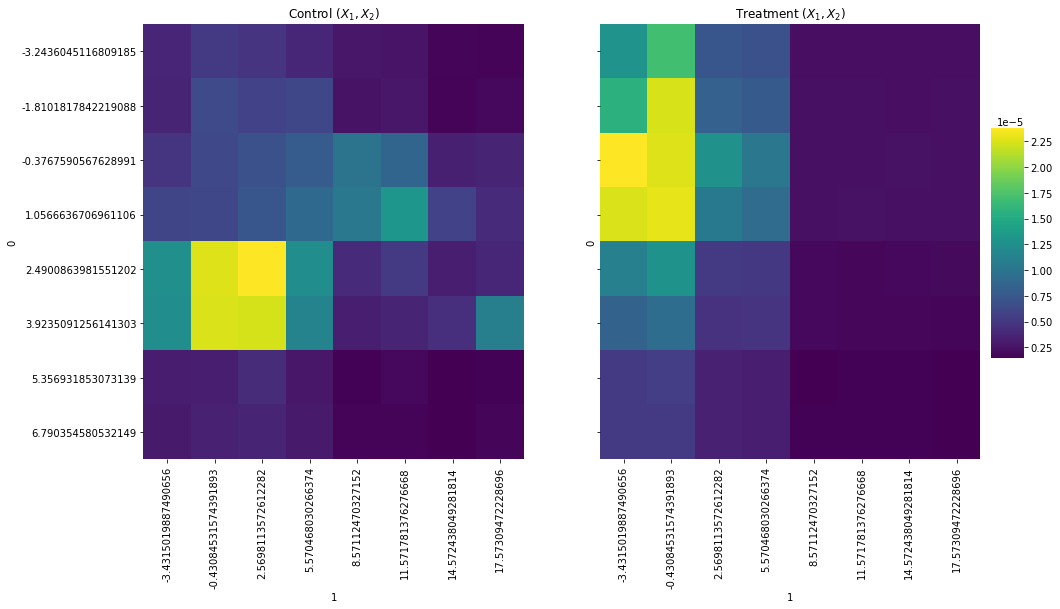

In [114]:
# 2d
import seaborn as sns

fig, axn = plt.subplots(ncols=2, figsize=(15, 8), sharey=True, sharex=True)
# fig2, axn2 = plt.subplots(ncols=2, figsize=(15, 8))#, sharey=True, sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])


for i, ax in enumerate(axn.flat):
    if i == 0:
        d = pd.concat([pd.Series(d_res['control']['pi'], name='y') ,pd.DataFrame(np.fliplr(pt.arr_med))], axis=1)
        df_heat = d.pivot(0, 1, "y")
        ax.set_title('Control $(X_1,X_2)$')
    else:
        d = pd.concat([pd.Series(d_res['treated']['pi'], name='y') ,pd.DataFrame(np.fliplr(pt.arr_med))], axis=1)
        df_heat = d.pivot(0, 1, "y")
        ax.set_title('Treatment $(X_1,X_2)$')
    sns.heatmap((df_heat), ax=ax,
                cbar=i == 0,
                vmin=(d['y']).min(), vmax=(d['y']).max(),
                cbar_ax=None if i else cbar_ax,
                cmap = plt.get_cmap('viridis'))
    


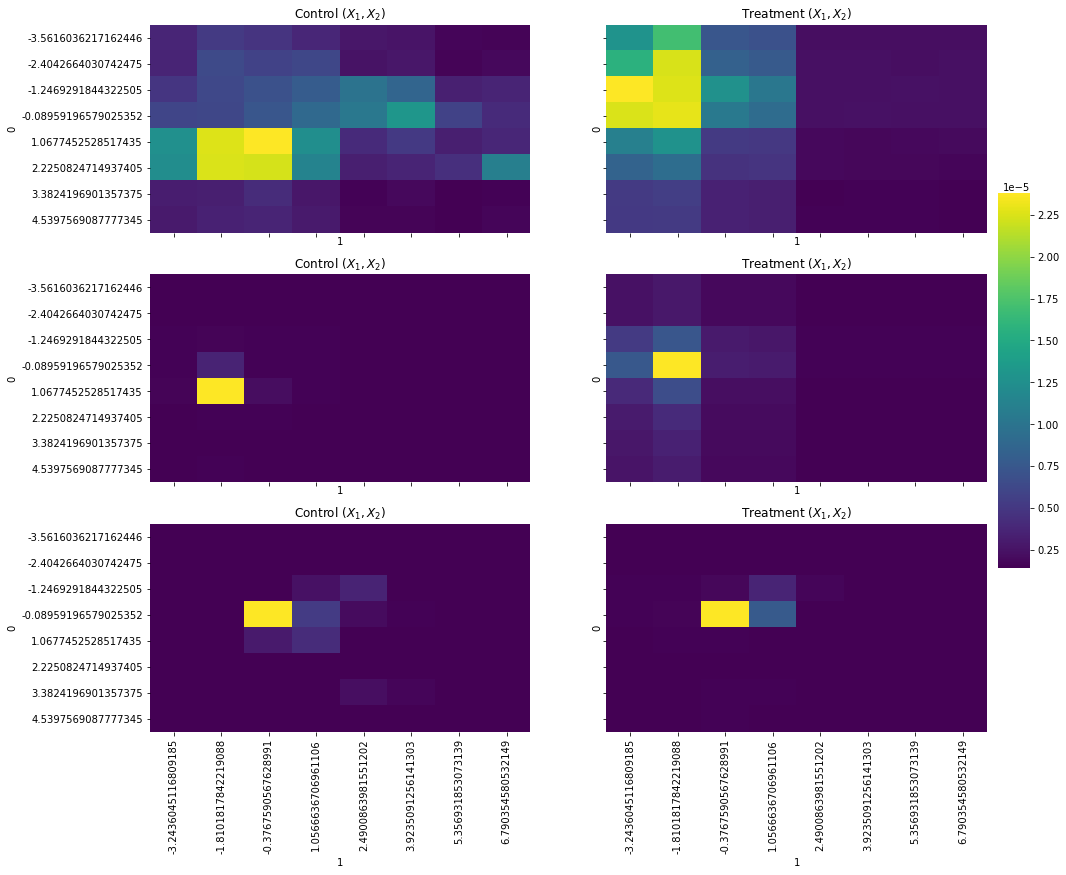

In [133]:
# 3d
import seaborn as sns

fig, axn = plt.subplots(nrows=3, ncols=2, figsize=(15, 13), sharey=True, sharex=True)
# fig2, axn2 = plt.subplots(ncols=2, figsize=(15, 8))#, sharey=True, sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

col_list = [[0,1],[0,2],[1,2]]
k = 0
for i, ax in enumerate(axn.flat):
    if (i % 2) == 0:
        d = pd.concat([pd.Series(d_res['control']['pi'], name='y') 
                       ,pd.DataFrame(np.fliplr(pt.arr_med[:,col_list[k]]))], axis=1)
        cd = d.drop_duplicates(subset=[0, 1])
        df_heat = cd.pivot(0, 1, "y")
        ax.set_title('Control $(X_1,X_2)$')
    else:
        d = pd.concat([pd.Series(d_res['treated']['pi'], name='y') 
                       ,pd.DataFrame(np.fliplr(pt.arr_med[:,col_list[k]]))], axis=1)
        cd = d.drop_duplicates(subset=[0, 1])
        df_heat = cd.pivot(0, 1, "y")
        ax.set_title('Treatment $(X_1,X_2)$')
        k += 1
    sns.heatmap((df_heat), ax=ax,
                cbar=i == 0,
                vmin=(cd['y']).min(), vmax=(cd['y']).max(),
                cbar_ax=None if i else cbar_ax,
                cmap = plt.get_cmap('viridis'))
    

In [129]:
d = pd.concat([pd.Series(d_res['control']['pi'], name='y') 
               ,pd.DataFrame(np.fliplr(pt.arr_med[:,col_list[k]]))], axis=1)

In [131]:
col_list[k]

[0, 2]

# Data with many conditonal distributions

Based simply on:
$$ P(X,A)=P(A=0)\cdot P(X|A=0) + P(A=1)\cdot P(X|A=1)$$

In [147]:
import itertools
binary_optins = list(itertools.product((0, 1), repeat=4))
l = []
neglected_obs = 2 + 1 + 1 + 1 + 2 + 6
weighted_res = dict()
weighted_res_treated = dict()
i=0
for row in binary_optins:
    tr = 'treated' + str(row)
    cr = 'control' + str(row)
    if tr in d_res.keys():
        
        weighted_p = (d_res[tr]['obs'] + d_res[cr]['obs']) / (X.shape[0] - neglected_obs) # number of obs. for ATE estimation
        p_x = (d_res[tr]['p_x_a']['p_x'] + d_res[cr]['p_x_a']['p_x'])/2
        weighted_res[i] = (d_res[tr]['y_given_x']['y'] - d_res[cr]['y_given_x']['y']) * p_x * weighted_p
        
        weighted_p = (d_res[tr]['obs']) / (185 - neglected_obs)# number of treated for ATT estimation
        p_x = d_res[tr]['p_x_a']['p_x']
        weighted_res_treated[i] = (d_res[tr]['y_given_x']['y'] - d_res[cr]['y_given_x']['y']) * p_x * weighted_p
        i+=1

In [252]:
import itertools
binary_optins = list(itertools.product((0, 1), repeat=4))
l = []
neglected_obs = 2 + 1 + 1 + 1 + 2 + 6
weighted_res = dict()
weighted_res_treated = dict()
i=0
for row in binary_optins[:-1]: # I neglect the last element since it is empty
    tr = 'treated' + str(row)
    cr = 'control' + str(row)
    if tr in d_res.keys():
        print(tr)
        weighted_p = (d_res[tr]['obs'] + d_res[cr]['obs']) / X.shape[0] #(X.shape[0] - neglected_obs) # number of obs. for ATE estimation
        weighted_tr = (d_res[tr]['obs']) / (185-neglected_obs)
        weighted_res_treated[i] = (d_res[tr]['y_given_x']['y'] - d_res[cr]['y_given_x']['y']) * weighted_tr * d_res[tr]['p_x_a']['p_x']
        if d_res[tr]['obs'] < 7:
            print(row, np.mean(d_res_lo[tr]['y_given_x']['y']))
            weighted_res_treated[i] = (d_res_lo[tr]['y_given_x']['y'] - d_res[cr]['y_given_x']['y']) * weighted_tr * (d_res[tr]['p_x_a']['p_x']+ 1/64)            
        else:
            weighted_res_treated[i] = (d_res[tr]['y_given_x']['y'] - d_res[cr]['y_given_x']['y']) * weighted_tr * d_res[tr]['p_x_a']['p_x']
#            weighted_res_treated[i] =  weighted_tr * d_res[tr]['p_x_a']['p_x']
        p_x = (d_res[tr]['p_x_a']['p_x'] + d_res[cr]['p_x_a']['p_x'])/2
        weighted_res[i] =  p_x * weighted_p
        i+=1

treated(0, 0, 0, 0)
treated(0, 0, 0, 1)
treated(0, 0, 1, 0)
(0, 0, 1, 0) 60586.789999999986
treated(0, 0, 1, 1)
(0, 0, 1, 1) 60586.789999999986
treated(0, 1, 0, 0)
(0, 1, 0, 0) 60586.789999999986
treated(0, 1, 0, 1)
treated(0, 1, 1, 0)
(0, 1, 1, 0) 60586.789999999986
treated(0, 1, 1, 1)
(0, 1, 1, 1) 60586.789999999986
treated(1, 0, 0, 0)
treated(1, 0, 0, 1)
treated(1, 0, 1, 0)


KeyError: 'y_given_x'

In [257]:
binary_optins[10]

(1, 0, 1, 0)

In [255]:
d_res_lo['treated(0, 0, 1, 0)']['y_given_x']

,y,0,1
0,60586.79,11.6125,-16526.357438
1,60586.79,11.6125,9181.309687
2,60586.79,11.6125,34888.976812
3,60586.79,11.6125,60596.643937
4,60586.79,11.6125,86304.311062
...,...,...,...
59,60586.79,59.3875,60596.643937
60,60586.79,59.3875,86304.311062
61,60586.79,59.3875,112011.978187
62,60586.79,59.3875,137719.645312


In [253]:
print(np.sum(np.sum(pd.DataFrame(weighted_res_treated), axis=0)))
pd.DataFrame(weighted_res_treated)

1820.3769436100747


,0,1,2,3,4,5,6,7,8,9,10
0,2.045069,1.143729,5.084881,3.200659,3.480119,4.550444,2.857317,6.417879,-6.611640,-12.925611,NaN
1,-0.151636,-0.713911,5.763578,3.363533,3.688709,3.066853,3.223254,7.160117,-16.257328,-30.146983,NaN
2,6.370339,2.036273,4.685846,2.598856,2.941791,4.823887,2.437324,6.076607,3.829681,7.349283,NaN
3,3.666778,2.356760,4.120844,2.581870,2.854224,3.992550,2.198120,6.184050,3.881524,5.727757,NaN
4,-0.725021,1.475931,-0.249647,1.687573,2.061602,1.780401,1.649659,3.760558,1.611080,0.708820,NaN
...,...,...,...,...,...,...,...,...,...,...,...
59,3.644889,5.463467,2.167533,2.729411,2.512366,4.321885,2.627145,6.224845,6.650810,7.654917,NaN
60,1.318389,1.575977,-2.842343,1.489332,1.903123,2.267557,1.482302,3.574344,2.024717,1.927842,NaN
61,0.797844,2.243136,-1.961180,1.288554,1.720099,2.106524,1.065941,3.959597,1.109807,2.244009,NaN
62,1.123285,2.280638,-1.631178,1.395355,1.556047,2.466033,1.200490,3.853569,0.489926,1.846122,NaN


In [208]:
tr = 'treated(0, 0, 0, 0)'
weighted_tr = (d_res[tr]['obs']) / (185-neglected_obs)
d_res[tr]['p_x_a']['p_x']

0     0.024078
1     0.033936
2     0.013794
3     0.013786
4     0.006321
        ...   
59    0.008781
60    0.005135
61    0.005127
62    0.005112
63    0.005035
Name: p_x, Length: 64, dtype: float16

In [201]:
print('p_x :{:f}'.format(np.sum(p_x)))

p_x :1.995117


In [202]:
print(np.sum(np.sum(pd.DataFrame(weighted_res))))
pd.DataFrame(weighted_res)

1.334


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.003803,0.002205,0.000042,0.000037,0.000032,0.000394,0.000034,0.000031,0.000269,0.000224,0.000033,0.000320
1,0.005379,0.003284,0.000078,0.000072,0.000061,0.000581,0.000060,0.000057,0.000477,0.000393,0.000066,0.000446
2,0.002207,0.001193,0.000067,0.000034,0.000020,0.000217,0.000026,0.000022,0.000138,0.000112,0.000033,0.000204
3,0.002188,0.001195,0.000044,0.000026,0.000017,0.000215,0.000021,0.000019,0.000128,0.000104,0.000022,0.000192
4,0.000993,0.000507,0.000008,0.000004,0.000004,0.000093,0.000004,0.000004,0.000044,0.000032,0.000004,0.000082
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.001415,0.000610,0.000083,0.000042,0.000015,0.000095,0.000030,0.000031,0.000074,0.000068,0.000034,0.000177
60,0.000808,0.000354,0.000016,0.000004,0.000004,0.000058,0.000004,0.000004,0.000032,0.000024,0.000006,0.000075
61,0.000806,0.000356,0.000012,0.000004,0.000003,0.000058,0.000004,0.000004,0.000032,0.000024,0.000005,0.000077
62,0.000803,0.000351,0.000010,0.000004,0.000003,0.000058,0.000004,0.000004,0.000031,0.000024,0.000004,0.000075


In [170]:
import itertools
binary_optins = list(itertools.product((0, 1), repeat=4))
l = []
neglected_obs = 2 + 1 + 1 + 1 + 2 + 6
weighted_res = dict()
weighted_res_treated = dict()
i=0
for row in binary_optins:
    tr = 'treated' + str(row)
    cr = 'control' + str(row)
    if tr in d_res.keys():
        
        weighted_p = (d_res[tr]['obs'] + d_res[cr]['obs']) / (X.shape[0] - neglected_obs) # number of obs. for ATE estimation
        p_x = (d_res[tr]['p_x_a']['p_x'] + d_res[cr]['p_x_a']['p_x'])/2
        weighted_res[i] = (d_res[tr]['y_given_x']['y'] - d_res[cr]['y_given_x']['y']) * p_x * weighted_p
        
        if (np.isnan(weighted_res[i].iloc[0])) & (not(tr == 'treated(1, 0, 1, 0)')):
            weighted_p = (d_res_lo[tr]['obs'] + d_res[cr]['obs'])
            p_x = (d_res_lo[tr]['p_x_a']['p_x'] + d_res[cr]['p_x_a']['p_x'])/2
            weighted_res[i] = (d_res_lo[tr]['y_given_x']['y'] - d_res[cr]['y_given_x']['y']) * p_x * weighted_p
        i+=1

In [178]:
d_res['treated(0, 0, 0, 0)']['p_x_a']#['treated(0, 0, 1, 0)']

,p_x,0,1
0,0.024078,11.6125,-16526.357438
1,0.033936,11.6125,9181.309687
2,0.013794,11.6125,34888.976812
3,0.013786,11.6125,60596.643937
4,0.006321,11.6125,86304.311062
...,...,...,...
59,0.008781,59.3875,60596.643937
60,0.005135,59.3875,86304.311062
61,0.005127,59.3875,112011.978187
62,0.005112,59.3875,137719.645312


In [172]:
pd.DataFrame(weighted_res)

,0,1,2,3,4,5,6,7,8,9,10,11
0,3.971316,1.016639,13148.018862,14353.532122,13381.548415,0.813453,11819.569938,11916.212333,-0.369697,-0.482410,NaN,0.670831
1,-0.295438,-0.637718,27393.009097,29513.311546,27480.735830,0.564028,23372.022650,24735.737607,-0.924615,-1.136278,NaN,0.968477
2,12.530863,1.821185,19010.942275,10643.172354,7219.531846,0.849021,7695.792051,8165.887040,0.229198,0.323404,NaN,0.540997
3,7.150460,2.095528,11086.586672,8094.055650,5908.886774,0.699205,5636.385601,6984.677354,0.221031,0.231850,NaN,0.528506
4,-1.400514,1.300879,-127.565842,803.208970,1053.349382,0.304355,882.734324,857.399410,0.086513,0.025252,NaN,0.165997
...,...,...,...,...,...,...,...,...,...,...,...,...
59,7.220026,5.027652,10955.676907,13810.635950,4630.648019,0.847361,9730.848935,11761.591707,0.421516,0.376759,NaN,1.124710
60,2.549543,1.392641,-2756.050751,784.466321,810.071345,0.397749,777.243058,890.864867,0.111517,0.071894,NaN,0.359209
61,1.541768,1.983826,-1460.942102,675.986381,720.781371,0.369204,555.216680,910.495924,0.061189,0.083149,NaN,0.237809
62,2.170690,2.015518,-943.972896,705.449888,615.197452,0.432564,627.956600,942.436000,0.026999,0.068717,NaN,0.276168


In [117]:
np.sum((d_res['treated(0, 0, 0, 0)']['y_given_x']['y'] - d_res['control(0, 0, 0, 0)']['y_given_x']['y']) * d_res['treated(0, 0, 0, 0)']['p_x_a']['p_x'])

4148.375024861366

In [171]:
print('ATE: {:f}'.format(np.sum(np.sum(pd.DataFrame(weighted_res)))))
print('ATT: {:f}'.format(np.sum(np.sum(pd.DataFrame(weighted_res_treated)))))

ATE: 284879099.491479
ATT: 0.000000


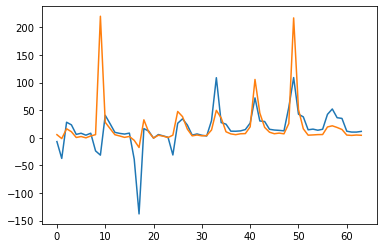

In [142]:
plt.plot(np.sum(pd.DataFrame(weighted_res_treated), axis=1))
plt.plot(np.sum(pd.DataFrame(weighted_res), axis=1))

In [135]:
(d_res[tr]['y_given_x']['y'] - d_res[cr]['y_given_x']['y'])

KeyError: 'y_given_x'

In [140]:
binary_optins = list(itertools.product((0, 1), repeat=4))
tr = 'treated' + str(binary_optins[11])
cr = 'control' + str(binary_optins[11])

(d_res[tr]['y_given_x']['y'] - d_res[cr]['y_given_x']['y'])

0      4194.231845
1      4344.321344
2      5292.838899
3      5490.608508
4      4055.051223
          ...     
59    12695.852016
60     9527.054550
61     6202.990492
62     7312.321526
63     8203.382585
Name: y, Length: 64, dtype: float64

In [70]:

tr = 'treated' + str((0, 0, 0, 1))
cr = 'control' + str((0, 0, 0, 1))
d_res[cr]['y_given_x']['y']

0     25773.953834
1     21849.520227
2     31584.271000
3     31146.066983
4     40897.839764
          ...     
59    28088.415251
60    43837.134810
61    40478.957401
62    40334.461013
63    41518.859908
Name: y, Length: 64, dtype: float64

In [35]:
tr = 'treated' + str((0,0,0,0))

In [36]:
tr in d_res.keys()

True

In [39]:
d_res[tr]['obs']

7